## 1. Import dependencies

In [2]:
import os
import random
from collections import namedtuple
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from pandas import read_json
from sklearn import preprocessing

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(31337)

## 2. Prepare dataset

In [5]:
DATA_DIR = "../botify/data/"

In [6]:
data = pd.read_json(DATA_DIR + "sessions_100000_contextual.json", lines=True)
tracks = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [7]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2022-11-18 15:31:16.037,3255,2659,1.00,0.001204,7668.0,{}
1,next,2022-11-18 15:31:16.048,3255,7668,0.30,0.000472,3638.0,{}
2,next,2022-11-18 15:31:16.055,3255,3638,0.43,0.000488,15373.0,{}
3,next,2022-11-18 15:31:16.062,3255,15373,0.46,0.000526,424.0,{}
4,next,2022-11-18 15:31:16.069,3255,424,1.00,0.000555,2251.0,{}


In [8]:
tracks.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [9]:
data_with_track_info = pd.merge(data, tracks, how="left", on=["track"])
data_with_track_info.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,artist,title
0,next,2022-11-18 15:31:16.037,3255,2659,1.00,0.001204,7668.0,{},Young Money featuring Lloyd,BedRock (Radio Edit) (feat.Lloyd)
1,next,2022-11-18 15:31:16.048,3255,7668,0.30,0.000472,3638.0,{},Basshunter Feat. DJ Mental Theos Bazzheadz,Now You're Gone
2,next,2022-11-18 15:31:16.055,3255,3638,0.43,0.000488,15373.0,{},My Chemical Romance,Welcome To The Black Parade (Album Version)
3,next,2022-11-18 15:31:16.062,3255,15373,0.46,0.000526,424.0,{},Skillet,Falling Inside The Black (Album Version)
4,next,2022-11-18 15:31:16.069,3255,424,1.00,0.000555,2251.0,{},Paramore,The Only Exception (Album Version)


In [10]:
Pair = namedtuple("Session", ["user_id", "start_track_id", "track_id", "artist_name", "time"])

def get_pairs(user_data):
    pairs = []
    first_track_in_session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first_track_in_session is None:
            first_track_in_session = row["track"]
        else:
            pairs.append(Pair(row["user"], first_track_in_session, row["track"], row["artist"], row["time"]))
        
        if row["message"] == "last":
            first_track_in_session = None

    return pairs

In [11]:
if not os.path.isfile("pairs_cached_json"):
    pairs = pd.DataFrame(
        data_with_track_info
        .groupby("user")
        .apply(get_pairs)
        .explode()
        .values
        .tolist(),
        columns=["user_id", "start_track_id", "track_id", "artist_name", "time"]
    )

    pairs.to_json("pairs_cached_json")
else:
    pairs = read_json("pairs_cached_json")

In [12]:
pairs.head()

,user_id,start_track_id,track_id,artist_name,time
0,0,6519,3733,Frightened Rabbit,0.0
1,0,6519,4496,Keri Hilson,0.0
2,0,6519,6024,Usher,0.0
3,0,6519,4184,Dr. Dre / Snoop Dogg,0.0
4,0,6519,12122,Kid Cudi / Billy Craven,0.0


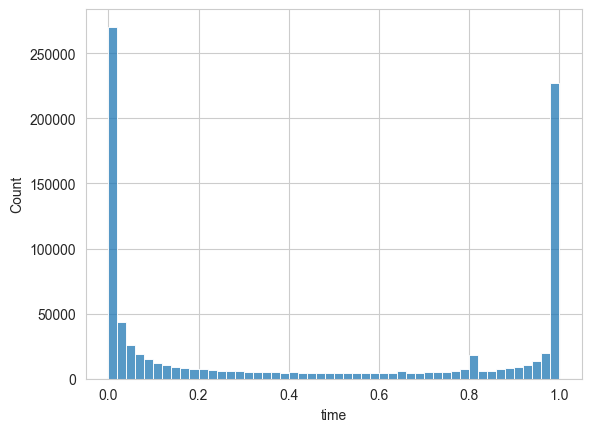

In [13]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

In [14]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(722382, 89625, 90582)

In [15]:
train_data.head(5)

,user_id,start_track_id,track_id,artist_name,time
0,0,6519,3733,Frightened Rabbit,0.0
2,0,6519,6024,Usher,0.0
3,0,6519,4184,Dr. Dre / Snoop Dogg,0.0
4,0,6519,12122,Kid Cudi / Billy Craven,0.0
7,0,6460,2119,Soltero,0.0


## 3. Define Model

Define data model for our model.
We will use LabelEncoder to transform artist name to artist index.

In [16]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, artist_names: np.ndarray, batch_size=2048, num_workers=2):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.batch_size = batch_size
      self.num_workers = num_workers
      self.features = ["user_id", "start_track_id", "track_id", "artist_id"]

      self.artist_encoder = preprocessing.LabelEncoder()
      self.artist_encoder.fit_transform(artist_names)

      self.train_data['artist_id'] = self.artist_encoder.transform(self.train_data['artist_name'])
      self.val_data['artist_id'] = self.artist_encoder.transform(self.val_data['artist_name'])
      self.test_data['artist_id'] = self.artist_encoder.transform(self.test_data['artist_name'])

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
        )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
        )
        
      if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )

  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=self.num_workers)

  def get_artist_encoder(self):
    return self.artist_encoder

Define configuration class for our model.

In [17]:
@dataclass
class ModelConfig:
    unique_users_count: int = 10000
    unique_tracks_count: int = 50000
    unique_artists_count: int = 12000
    user_embedding_dim: int = 10
    context_track_embedding_dim: int = 20
    track_embedding_dim: int = 20
    artist_embedding_dim: int = 10
    hidden_dims: list = field(default_factory=lambda: [512, 256, 128])
    dropout_prob: float = 0.2

Define model structure.

In [26]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.user_embedding_dim = config.user_embedding_dim
        self.context_track_embedding_dim = config.context_track_embedding_dim
        self.track_embedding_dim = config.track_embedding_dim
        self.artist_embedding_dim = config.artist_embedding_dim
        self.hidden_dims = config.hidden_dims

        self.user_embedding = nn.Embedding(num_embeddings=config.unique_users_count, embedding_dim=self.user_embedding_dim)
        self.context_track_embedding = nn.Embedding(num_embeddings=config.unique_tracks_count, embedding_dim=self.context_track_embedding_dim)
        self.track_embedding = nn.Embedding(num_embeddings=config.unique_tracks_count, embedding_dim=self.track_embedding_dim)
        self.artist_embedding = nn.Embedding(num_embeddings=config.unique_artists_count, embedding_dim=self.artist_embedding_dim)

        context_transformation_layers = [
            nn.Linear(self.user_embedding_dim + self.context_track_embedding_dim, self.hidden_dims[0]),
            nn.BatchNorm1d(self.hidden_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Dropout(config.dropout_prob)
        ]
        for i in range(0, len(self.hidden_dims) - 1):
            context_transformation_layers.extend([
                nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1]),
                nn.BatchNorm1d(self.hidden_dims[i + 1]),
                nn.LeakyReLU(0.1),
                nn.Dropout(config.dropout_prob)
            ])
        self.context_transformation = nn.Sequential(
            *context_transformation_layers
        )

        track_transformation_layers = [
            nn.Linear(self.track_embedding_dim + self.artist_embedding_dim, self.hidden_dims[0]),
            nn.BatchNorm1d(self.hidden_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Dropout(config.dropout_prob)
        ]
        for i in range(0, len(self.hidden_dims) - 1):
            track_transformation_layers.extend([
                nn.Linear(self.hidden_dims[i], self.hidden_dims[i + 1]),
                nn.BatchNorm1d(self.hidden_dims[i + 1]),
                nn.LeakyReLU(0.1),
                nn.Dropout(config.dropout_prob)
            ])
        self.track_transformation = nn.Sequential(
            *track_transformation_layers
        )

    def forward(self, x):
        context_data = self.context_transformation(torch.cat((self.user_embedding(x[:, 0]), self.context_track_embedding(x[:, 1])), dim=1))
        track_data = self.track_transformation(torch.cat((self.track_embedding(x[:, 2]), self.artist_embedding(x[:, 3])), dim=1))

        return torch.sum(context_data * track_data, dim=1)

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def predict_step(self, batch, batch_idx):
        x, = batch
        predictions = self.forward(x)

        return predictions

    def get_context_embedding(self, user_id: torch.Tensor, track_id: torch.Tensor) -> torch.Tensor:
        input = torch.cat((self.user_embedding(user_id), self.context_track_embedding(track_id)), dim=0).unsqueeze(0)
        context_embeddings = self.context_transformation(input)

        return context_embeddings[0]

    def get_track_embeddings(self, tracks: torch.Tensor, artists: torch.Tensor) -> torch.Tensor:
        track_embeddings = self.track_transformation(
            torch.cat((self.track_embedding(tracks), self.artist_embedding(artists)), dim=1))

        return track_embeddings

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

## 4. Train Model

In [19]:
model_config = ModelConfig(
    unique_users_count=10000,
    unique_tracks_count=50000,
    unique_artists_count=12000,
    user_embedding_dim=30,
    context_track_embedding_dim=100,
    track_embedding_dim=100,
    artist_embedding_dim=30,
    hidden_dims=[512, 256, 128],
    dropout_prob = 0.0
)

In [20]:
net = ContextualRanker(model_config)
data_module = ContextualRankerData(train_data, val_data, test_data, tracks["artist"].unique())

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

C:\Users\Kirill\AppData\Local\Temp\ipykernel_34028\3420447237.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data['artist_id'] = self.artist_encoder.transform(self.train_data['artist_name'])
C:\Users\Kirill\AppData\Local\Temp\ipykernel_34028\3420447237.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.val_data['artist_id'] = self.artist_encoder.transform(self.val_data['artist_name'])
C:\Users\Kirill\AppData\Local\Temp\ipykernel_34028\3420447237.py:16: SettingWithCopyWarning: 
A valu

In [ ]:
trainer.fit(
    net, 
    data_module
)

In [28]:
print(checkpoint_callback.best_model_path)
best: ContextualRanker = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, config=model_config)

C:\Users\Kirill\Documents\repos\mobod\atp-mobod\recsys\jupyter\lightning_logs\version_15\checkpoints\epoch=47-step=16944.ckpt


## 5. Check model performance on test dataset

In [24]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Kirill\Documents\repos\mobod\atp-mobod\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.1872759759426117
        rdm_loss            0.2753289043903351
        test_loss           0.09204543381929398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.09204543381929398,
  'avg_loss': 0.1872759759426117,
  'rdm_loss': 0.2753289043903351}]

## 6. Compute track embeddings and save for future use

In [29]:
artists_tensor = torch.tensor(data_module.get_artist_encoder().transform(tracks["artist"]))

best.eval()
with torch.no_grad():
    track_embeddings = best.get_track_embeddings(
        torch.tensor(tracks["track"]),
        artists_tensor
    )

    torch.save(track_embeddings, "track_embeddings.pt")